In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd

# Audio + signal processing
import librosa

# For potential plots later (EDA, spectrogram visualisation)
import matplotlib.pyplot as plt

# For label encoding
from sklearn.preprocessing import LabelEncoder


In [2]:
AUDIO_DIR = r"C:\Users\Emna Othmani\OneDrive - ENSEA\Bureau\DEEP_LEARNING\ESC-50-master\audio"
META_PATH = r"C:\Users\Emna Othmani\OneDrive - ENSEA\Bureau\DEEP_LEARNING\ESC-50-master\meta\esc50.csv"

meta = pd.read_csv(META_PATH)
print(meta.head())
print("Number of clips:", len(meta))
print("Number of classes:", meta['category'].nunique())
print("Sample files:", os.listdir(AUDIO_DIR)[:5])


            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
Number of clips: 2000
Number of classes: 50
Sample files: ['1-100032-A-0.wav', '1-100038-A-14.wav', '1-100210-A-36.wav', '1-100210-B-36.wav', '1-101296-A-19.wav']


SIMPLE EDA


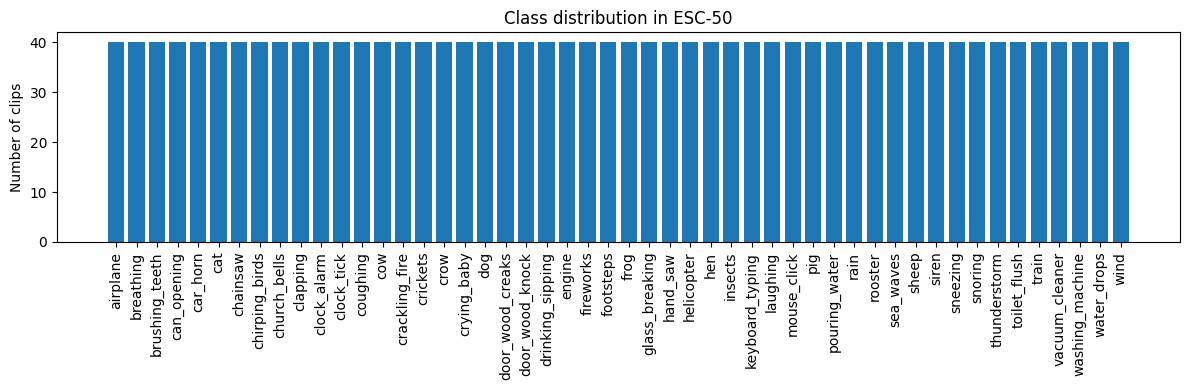

In [3]:
import matplotlib.pyplot as plt

class_counts = meta['category'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=90)
plt.ylabel("Number of clips")
plt.title("Class distribution in ESC-50")
plt.tight_layout()
plt.savefig("eda_class_distribution.png", dpi=300)
plt.show()


DATA PREPARATION

In [4]:
TARGET_SR = 16000
CLIP_DURATION = 5.0  # seconds
N_SAMPLES = int(TARGET_SR * CLIP_DURATION)

def load_waveform(filename, audio_dir=AUDIO_DIR,
                  target_sr=TARGET_SR, n_samples=N_SAMPLES):
    """
    Load an ESC-50 clip, resample to target_sr, convert to mono,
    and pad/truncate to fixed length.
    """
    filepath = os.path.join(audio_dir, filename)
    y, sr = librosa.load(filepath, sr=target_sr, mono=True)

    # Pad or truncate to exactly n_samples
    if len(y) > n_samples:
        y = y[:n_samples]
    elif len(y) < n_samples:
        pad_width = n_samples - len(y)
        y = np.pad(y, (0, pad_width), mode="constant")

    # Optional: normalise amplitude
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    return y


In [5]:
example_row = meta.iloc[0]
y = load_waveform(example_row['filename'])
print("Waveform shape:", y.shape)
print("Fold:", example_row['fold'], "| Class:", example_row['category'])


Waveform shape: (80000,)
Fold: 1 | Class: dog


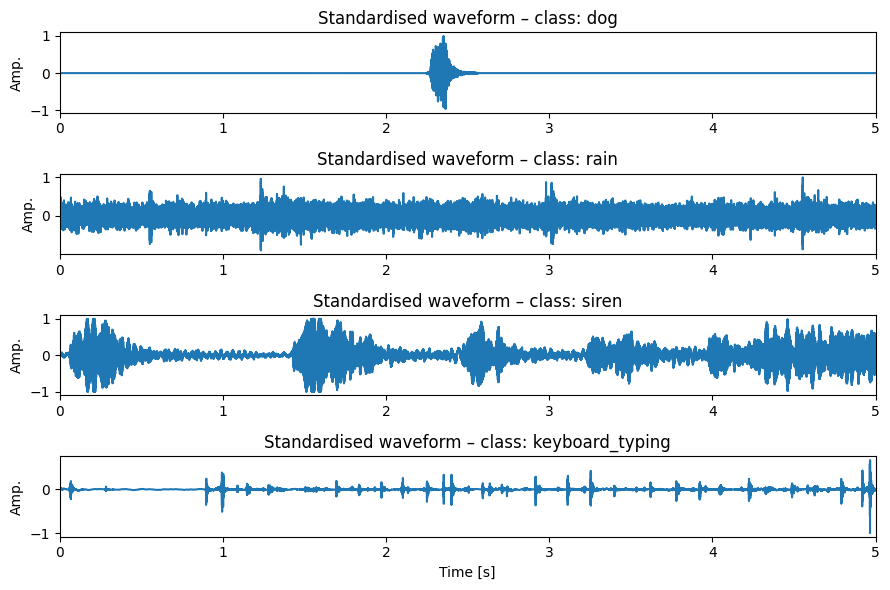

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Choose some classes to illustrate
example_classes = ["dog", "rain", "siren", "keyboard_typing"]

rows = []
for cls in example_classes:
    row_cls = meta[meta["category"] == cls].iloc[0]
    rows.append(row_cls)

duration = 5.0  # seconds
t = np.linspace(0, duration, N_SAMPLES)  # N_SAMPLES = 80000 from before

plt.figure(figsize=(9, 6))

for i, row in enumerate(rows):
    filename = row["filename"]
    label = row["category"]

    y_std = load_waveform(filename)  # mono, 16 kHz, fixed length

    plt.subplot(len(rows), 1, i + 1)
    plt.plot(t, y_std)
    plt.xlim(0, duration)
    plt.ylabel("Amp.")
    plt.title(f"Standardised waveform – class: {label}")
    if i == len(rows) - 1:
        plt.xlabel("Time [s]")

plt.tight_layout()
plt.savefig("standardised_waveforms_multi.png", dpi=300)
plt.show()


In [7]:
def extract_mfcc_sequence(y, sr=TARGET_SR, n_mfcc=40,
                          n_fft=1024, hop_length=512):
    """
    Compute an MFCC sequence (time x n_mfcc) from a waveform y.
    """
    mfcc = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    # Transpose to (time_steps, n_mfcc)
    return mfcc.T


def mfcc_mean_from_sequence(mfcc_seq):
    """
    Compute a time-averaged MFCC vector from an MFCC sequence.
    """
    return mfcc_seq.mean(axis=0)


In [8]:
y = load_waveform(meta.iloc[0]['filename'])
mfcc_seq = extract_mfcc_sequence(y)
mfcc_mean = mfcc_mean_from_sequence(mfcc_seq)

print("MFCC sequence shape:", mfcc_seq.shape)  # (T, 40)
print("MFCC mean shape:", mfcc_mean.shape)     # (40,)


MFCC sequence shape: (157, 40)
MFCC mean shape: (40,)


In [9]:
def extract_melspectrogram(y, sr=TARGET_SR,
                           n_mels=128, n_fft=1024, hop_length=512):
    """
    Compute a log-Mel spectrogram (dB) from a waveform y.
    Returns a 2D array (n_mels x time).
    """
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db


In [10]:
melspec = extract_melspectrogram(y)
print("Mel-spectrogram shape:", melspec.shape)  # (n_mels, time_steps)


Mel-spectrogram shape: (128, 157)


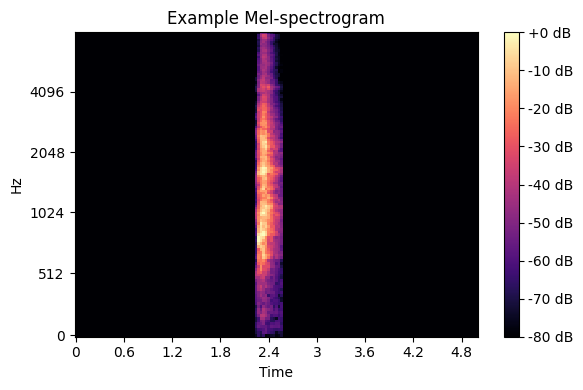

In [11]:
plt.figure(figsize=(6, 4))
librosa.display.specshow(melspec, sr=TARGET_SR,
                         x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Example Mel-spectrogram")
plt.tight_layout()
plt.show()


In [12]:
# ============================================
# 6. TRAIN / VAL / TEST SPLITS WITH FOLDS
# ============================================

from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np

# ------------------------------
# 1) Encode class labels
# ------------------------------
# meta['category'] is the string label (e.g. "dog")
label_encoder = LabelEncoder()
meta['label'] = label_encoder.fit_transform(meta['category'])

n_classes = len(label_encoder.classes_)
print("Number of classes:", n_classes)
print("Classes:", list(label_encoder.classes_))

# Quick check: distribution of labels
print("\nLabel distribution (all folds):")
print(Counter(meta['label']))

# ------------------------------
# 2) Define which folds go where
# ------------------------------
# ESC-50 has folds 1..5. We choose:
TRAIN_FOLDS = [1, 2, 3]
VAL_FOLDS   = [4]
TEST_FOLDS  = [5]

print("\nUsing folds")
print("Train folds:", TRAIN_FOLDS)
print("Val folds:  ", VAL_FOLDS)
print("Test folds: ", TEST_FOLDS)

# ------------------------------
# 3) Generic feature builder
# ------------------------------
def build_feature_set(meta_df, folds, feature_type="mfcc_mean"):
    """
    Build X, y for the given folds and feature type.

    feature_type:
        - "mfcc_mean" : time-averaged MFCCs (for MLP baseline)
        - "mfcc_seq"  : full MFCC sequences (for LSTM/GRU)
        - "melspec"   : log-Mel spectrograms (for CNN)
    """
    subset = meta_df[meta_df['fold'].isin(folds)]

    X = []
    y = []

    for _, row in subset.iterrows():
        filename = row['filename']
        label = row['label']

        # 1) Load waveform (resampled, mono, fixed length)
        signal = load_waveform(filename)

        # 2) Extract the right type of feature
        if feature_type == "mfcc_mean":
            mfcc_seq = extract_mfcc_sequence(signal)
            feat = mfcc_mean_from_sequence(mfcc_seq)          # shape (n_mfcc,)

        elif feature_type == "mfcc_seq":
            feat = extract_mfcc_sequence(signal)              # shape (T, n_mfcc)

        elif feature_type == "melspec":
            feat = extract_melspectrogram(signal)             # shape (n_mels, T)

        else:
            raise ValueError(f"Unknown feature_type: {feature_type}")

        X.append(feat)
        y.append(label)

    return X, np.array(y, dtype=np.int64)

# ------------------------------
# 4) Build MFCC-mean features (for MLP baseline)
# ------------------------------
X_train_mfcc_mean, y_train = build_feature_set(
    meta, TRAIN_FOLDS, feature_type="mfcc_mean"
)
X_val_mfcc_mean,   y_val   = build_feature_set(
    meta, VAL_FOLDS, feature_type="mfcc_mean"
)
X_test_mfcc_mean,  y_test  = build_feature_set(
    meta, TEST_FOLDS, feature_type="mfcc_mean"
)

# Convert lists -> numpy arrays
X_train_mfcc_mean = np.stack(X_train_mfcc_mean).astype("float32")
X_val_mfcc_mean   = np.stack(X_val_mfcc_mean).astype("float32")
X_test_mfcc_mean  = np.stack(X_test_mfcc_mean).astype("float32")

print("\nMFCC-mean features (for MLP):")
print("Train:", X_train_mfcc_mean.shape, y_train.shape)
print("Val:  ", X_val_mfcc_mean.shape,   y_val.shape)
print("Test: ", X_test_mfcc_mean.shape,  y_test.shape)

# ------------------------------
# 5) (Optional) Build MFCC sequences (for LSTM later)
# ------------------------------
X_train_mfcc_seq, y_train_seq = build_feature_set(
    meta, TRAIN_FOLDS, feature_type="mfcc_seq"
)
X_val_mfcc_seq,   y_val_seq   = build_feature_set(
    meta, VAL_FOLDS, feature_type="mfcc_seq"
)
X_test_mfcc_seq,  y_test_seq  = build_feature_set(
    meta, TEST_FOLDS, feature_type="mfcc_seq"
)

print("\nNumber of MFCC sequences (train/val/test):",
      len(X_train_mfcc_seq), len(X_val_mfcc_seq), len(X_test_mfcc_seq))
print("Example MFCC sequence shape:", X_train_mfcc_seq[0].shape)
# (Later we will pad these sequences to a fixed length for batching.)

# ------------------------------
# 6) (Optional) Build Mel-spectrograms (for CNN later)
# ------------------------------
X_train_melspec, y_train_cnn = build_feature_set(
    meta, TRAIN_FOLDS, feature_type="melspec"
)
X_val_melspec,   y_val_cnn   = build_feature_set(
    meta, VAL_FOLDS, feature_type="melspec"
)
X_test_melspec,  y_test_cnn  = build_feature_set(
    meta, TEST_FOLDS, feature_type="melspec"
)

print("\nNumber of Mel-spectrograms (train/val/test):",
      len(X_train_melspec), len(X_val_melspec), len(X_test_melspec))
print("Example Mel-spectrogram shape:", X_train_melspec[0].shape)
# Later we'll pad/crop and reshape them to (H, W, 1) for the CNN.


Number of classes: 50
Classes: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']

Label distribution (all folds):
Counter({18: 40, 7: 40, 46: 40, 43: 40, 20: 40, 3: 40, 16: 40, 9: 40, 23: 40, 6: 40, 0: 40, 33: 40, 35: 40, 45: 40, 39: 40, 48: 40, 8: 40, 10: 40, 31: 40, 49: 40, 24: 40, 25: 40, 13: 40, 2: 40, 4: 40, 14: 40, 28: 40, 21: 40, 36: 40, 30: 40, 32: 40, 29: 40, 22: 40, 1: 40, 17: 40, 27:

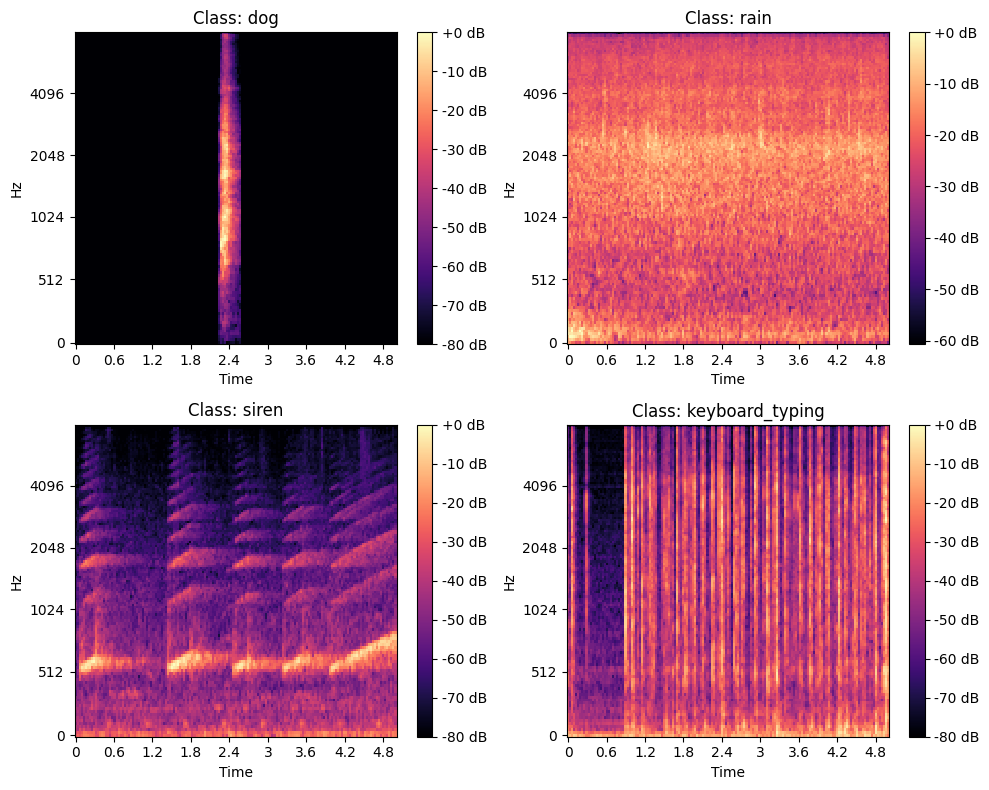

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display  # if not already imported

example_classes = ["dog", "rain", "siren", "keyboard_typing"]  # you can change these
rows = []

for cls in example_classes:
    row_cls = meta[meta["category"] == cls].iloc[0]
    rows.append(row_cls)

plt.figure(figsize=(10, 8))

for i, row in enumerate(rows):
    filename = row["filename"]
    label = row["category"]

    y_std = load_waveform(filename)
    melspec = extract_melspectrogram(y_std)      # shape (128, T)

    plt.subplot(2, 2, i + 1)
    librosa.display.specshow(
        melspec,
        sr=TARGET_SR,
        x_axis="time",
        y_axis="mel"
    )
    plt.title(f"Class: {label}")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()

plt.savefig("eda_melspectrograms_4classes.png", dpi=300)
plt.show()


Baseline Model (MLP)

Train: (1200, 40) (1200,)
Val:   (400, 40) (400,)
Test:  (400, 40) (400,)
Input dim: 40
Number of classes: 50


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,754 (65.45 KB)

 Trainable params: 16,754 (65.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0158 - loss: 4.0239 - val_accuracy: 0.0300 - val_loss: 3.8967
Epoch 2/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0358 - loss: 3.8561 - val_accuracy: 0.0450 - val_loss: 3.8309
Epoch 3/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0608 - loss: 3.7649 - val_accuracy: 0.0650 - val_loss: 3.7740
Epoch 4/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0775 - loss: 3.6901 - val_accuracy: 0.0650 - val_loss: 3.7081
Epoch 5/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1033 - loss: 3.5979 - val_accuracy: 0.0900 - val_loss: 3.6231
Epoch 6/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1208 - loss: 3.4877 - val_accuracy: 0.1225 - val_loss: 3.5288
Epoch 7/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1517 - loss: 3.3788 - val_accuracy: 0.1300 - val_loss: 3.4305
Epoch 8/80
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1750 - loss: 3.2616 - val_accuracy: 0.1525 - val_loss

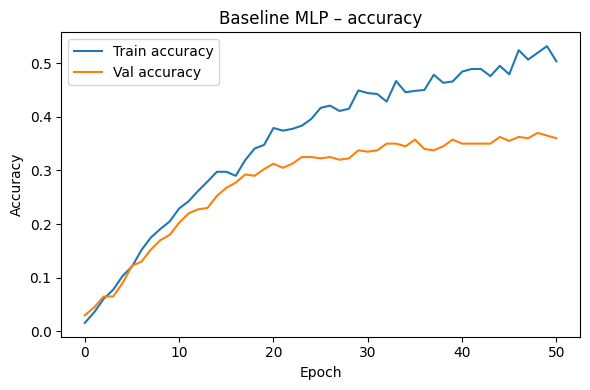

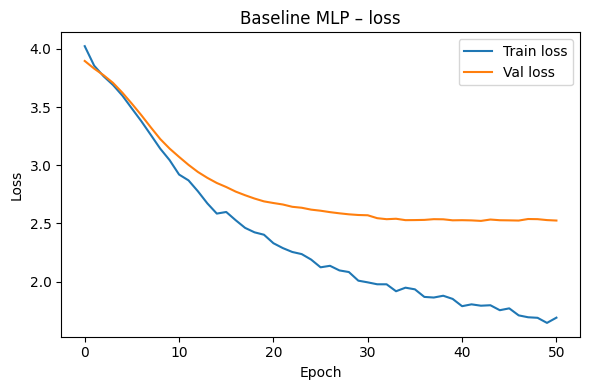

=== Final evaluation ===
Train accuracy: 0.723
Val accuracy:   0.350
Test accuracy:  0.292
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion matrix (test):
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.500     0.250     0.333         8
           1      0.250     0.125     0.167         8
           2      0.625     0.625     0.625         8
           3      0.250     0.250     0.250         8
           4      0.182     0.250     0.211         8
           5      0.000     0.000     0.000         8
           6      0.333     0.250     0.286         8
           7      0.000     0.000     0.000         8
           8      0.167     0.125     0.143         8
           9      0.250     0.250     0.250         8
          10      0.800     1.000     0.889         8
          11      0.000     0.000     0.000 

C:\Users\Emna Othmani\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Emna Othmani\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Emna Othmani\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

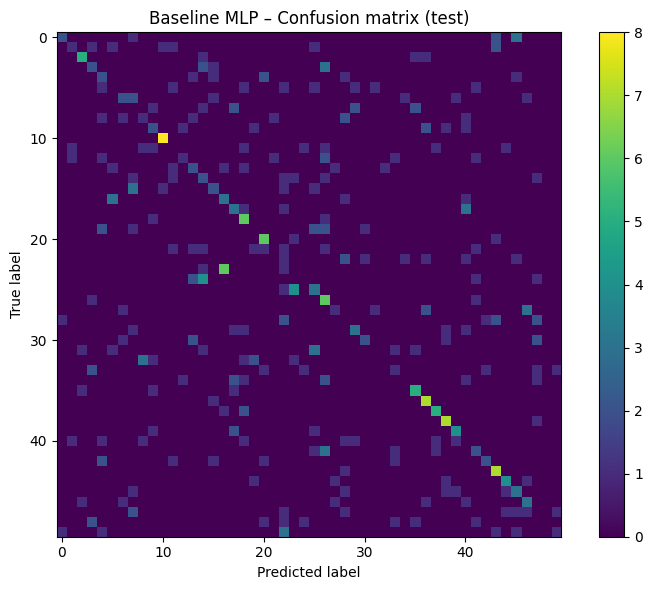

In [14]:
# ==============================
# 1. Imports
# ==============================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Just to be sure: check shapes
print("Train:", X_train_mfcc_mean.shape, y_train.shape)
print("Val:  ", X_val_mfcc_mean.shape,   y_val.shape)
print("Test: ", X_test_mfcc_mean.shape,  y_test.shape)

# ==============================
# 2. Basic normalisation (optional but recommended)
# ==============================
# Standardise features using training statistics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_mfcc_mean)
X_val   = scaler.transform(X_val_mfcc_mean)
X_test  = scaler.transform(X_test_mfcc_mean)

input_dim = X_train.shape[1]
print("Input dim:", input_dim)
print("Number of classes:", n_classes)

# ==============================
# 3. Build the MLP model
# ==============================
tf.random.set_seed(42)

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ==============================
# 4. Training with early stopping
# ==============================
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# ==============================
# 5. Plot training / validation curves
# ==============================
# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Baseline MLP – accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("mlp_baseline_accuracy.png", dpi=300)
plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline MLP – loss")
plt.legend()
plt.tight_layout()
plt.savefig("mlp_baseline_loss.png", dpi=300)
plt.show()

# ==============================
# 6. Evaluation on train/val/test
# ==============================
print("=== Final evaluation ===")
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss,   val_acc   = model.evaluate(X_val,   y_val,   verbose=0)
test_loss,  test_acc  = model.evaluate(X_test,  y_test,  verbose=0)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Val accuracy:   {val_acc:.3f}")
print(f"Test accuracy:  {test_acc:.3f}")

# ==============================
# 7. Confusion matrix and report on test set
# ==============================
y_test_pred_proba = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix (test):")
print(cm)

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, digits=3))

# Optional: plot confusion matrix as image
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Baseline MLP – Confusion matrix (test)")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("mlp_baseline_confusion_matrix.png", dpi=300)
plt.show()


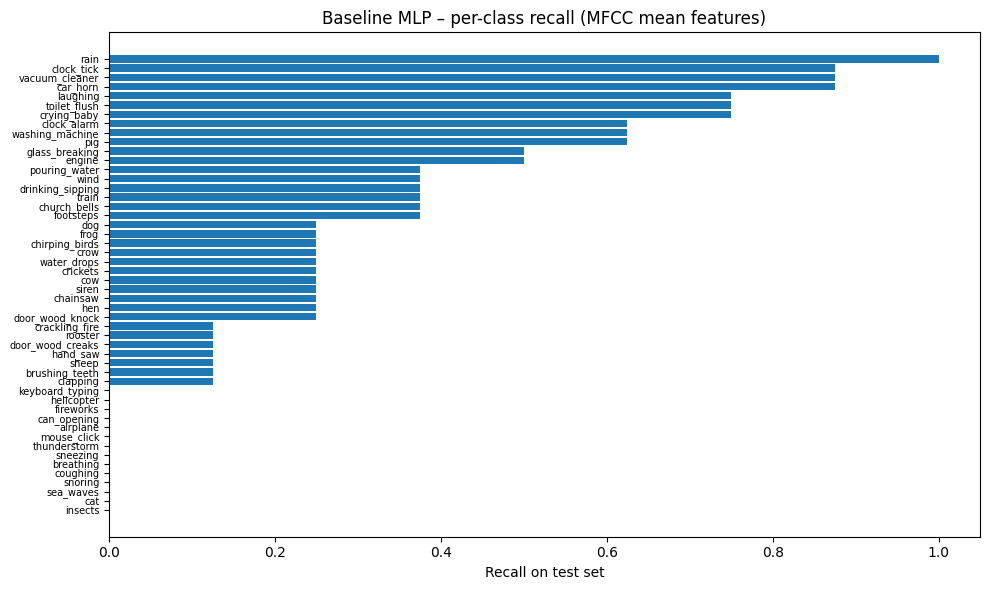

In [15]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
id_to_name = {row['target']: row['category'] for _, row in meta.iterrows()}

# classification report as dict (no noisy warnings)
report = classification_report(
    y_test, y_test_pred,
    digits=3,
    output_dict=True,
    zero_division=0
)

# assuming you have a mapping from id -> class name
# for example:
# id_to_name = {row['target']: row['category'] for _, row in meta.iterrows()}
# build ordered lists
class_ids = sorted([int(k) for k in report.keys() if k.isdigit()])
class_names = [id_to_name[i] for i in class_ids]
recalls = [report[str(i)]['recall'] for i in class_ids]

# sort by recall (worst to best) so it's clearer
order = np.argsort(recalls)
recalls_sorted = [recalls[i] for i in order]
names_sorted = [class_names[i] for i in order]

plt.figure(figsize=(10, 6))
plt.barh(range(len(names_sorted)), recalls_sorted)
plt.yticks(range(len(names_sorted)), names_sorted, fontsize=7)
plt.xlabel("Recall on test set")
plt.title("Baseline MLP – per-class recall (MFCC mean features)")
plt.tight_layout()
plt.savefig("mlp_baseline_per_class_recall.png", dpi=300)
plt.show()


In [16]:
# build a small summary table in Python
worst_idx = order[:3]
best_idx = order[-3:]

print("Worst classes:")
for i in worst_idx:
    print(class_ids[i], class_names[i], "recall =", recalls[i])

print("\nBest classes:")
for i in best_idx:
    print(class_ids[i], class_names[i], "recall =", recalls[i])


Worst classes:
7 insects recall = 0.0
5 cat recall = 0.0
11 sea_waves recall = 0.0

Best classes:
36 vacuum_cleaner recall = 0.875
38 clock_tick recall = 0.875
10 rain recall = 1.0


CNN


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [18]:
print(meta.head())
print("Columns:", list(meta.columns))
print("Folds:", sorted(meta["fold"].unique()))


            filename  fold  target        category  esc10  src_file take  \
0   1-100032-A-0.wav     1       0             dog   True    100032    A   
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A   
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A   
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B   
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A   

   label  
0     18  
1      7  
2     46  
3     46  
4     43  
Columns: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'label']
Folds: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


In [19]:
# ---- choose correct label column ----
if "label" in meta.columns:
    LABEL_COL = "label"
elif "target" in meta.columns:
    LABEL_COL = "target"
else:
    raise ValueError("I can't find label column. Expected 'label' or 'target' in meta.")

# ---- filename column ----
if "filename" not in meta.columns:
    raise ValueError("I can't find 'filename' column in meta.")

print("Using LABEL_COL =", LABEL_COL)


Using LABEL_COL = label


In [20]:
X_tr_mel, y_tr_mel = [], []
X_va_mel, y_va_mel = [], []
X_te_mel, y_te_mel = [], []

print("Building Mel-spectrogram datasets...")

for _, row in meta.iterrows():
    wav_path = os.path.join(AUDIO_DIR, row["filename"])
    fold = int(row["fold"])
    label = int(row[LABEL_COL])

    # waveform standardised (mono, 16kHz, 5s)
    y = load_waveform(wav_path)

    # Mel-spectrogram (128 x T)
    mel = extract_melspectrogram(y)

    if fold in [1, 2, 3]:
        X_tr_mel.append(mel)
        y_tr_mel.append(label)
    elif fold == 4:
        X_va_mel.append(mel)
        y_va_mel.append(label)
    elif fold == 5:
        X_te_mel.append(mel)
        y_te_mel.append(label)

X_tr_mel = np.array(X_tr_mel, dtype=np.float32)
X_va_mel = np.array(X_va_mel, dtype=np.float32)
X_te_mel = np.array(X_te_mel, dtype=np.float32)

y_tr_mel = np.array(y_tr_mel, dtype=np.int64)
y_va_mel = np.array(y_va_mel, dtype=np.int64)
y_te_mel = np.array(y_te_mel, dtype=np.int64)

print("Train:", X_tr_mel.shape, y_tr_mel.shape)
print("Val:  ", X_va_mel.shape, y_va_mel.shape)
print("Test: ", X_te_mel.shape, y_te_mel.shape)

num_classes = len(np.unique(y_tr_mel))
print("Num classes:", num_classes)


Building Mel-spectrogram datasets...
Train: (1200, 128, 157) (1200,)
Val:   (400, 128, 157) (400,)
Test:  (400, 128, 157) (400,)
Num classes: 50


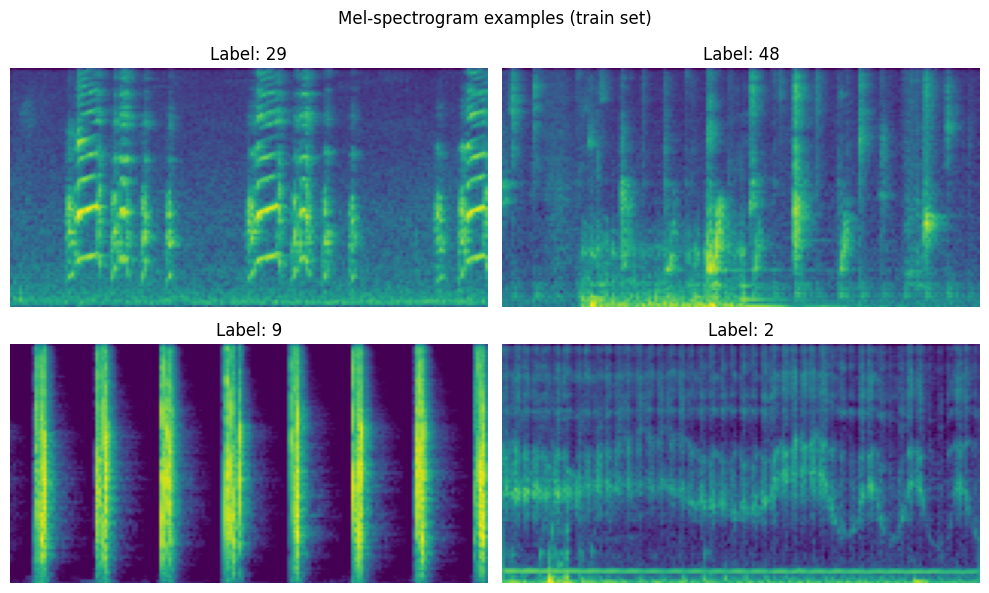

In [21]:
idx = np.random.choice(len(X_tr_mel), size=4, replace=False)

plt.figure(figsize=(10, 6))
for i, k in enumerate(idx, 1):
    plt.subplot(2, 2, i)
    plt.imshow(X_tr_mel[k], aspect="auto", origin="lower")
    plt.title(f"Label: {y_tr_mel[k]}")
    plt.axis("off")
plt.suptitle("Mel-spectrogram examples (train set)")
plt.tight_layout()
plt.show()


In [22]:
def add_channel(x):
    return x[..., None]  # (N, 128, 157, 1)

X_tr = add_channel(X_tr_mel)
X_va = add_channel(X_va_mel)
X_te = add_channel(X_te_mel)

print("CNN input shape:", X_tr.shape[1:])


CNN input shape: (128, 157, 1)


In [23]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def per_example_standardize(x):
    mean = tf.reduce_mean(x)
    std  = tf.math.reduce_std(x) + 1e-6
    return (x - mean) / std

def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(min(len(X), 2000), reshuffle_each_iteration=True)
    ds = ds.map(lambda xx, yy: (per_example_standardize(xx), yy),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_tr, y_tr_mel, training=True)
val_ds   = make_ds(X_va, y_va_mel)
test_ds  = make_ds(X_te, y_te_mel)

print("Datasets ready.")


Datasets ready.


In [24]:
def conv_block(x, filters, drop):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(drop)(x)
    return x

inputs = keras.Input(shape=X_tr.shape[1:])
x = inputs

x = conv_block(x, 32, 0.15)
x = conv_block(x, 64, 0.20)
x = conv_block(x, 128, 0.25)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

cnn = keras.Model(inputs, outputs, name="CNN_MelSpectrogram")
cnn.summary()


Model: "CNN_MelSpectrogram"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 157, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 157, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 157, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 157, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 157, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 157, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 157, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 78, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 78, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 78, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 78, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 39, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 39, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 39, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 39, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 39, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 310,738 (1.19 MB)

 Trainable params: 309,842 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

In [25]:
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
print("Compiled.")


Compiled.


In [26]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1),
]

EPOCHS = 80
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 768ms/step - accuracy: 0.0475 - loss: 3.7982 - val_accuracy: 0.0225 - val_loss: 3.9358 - learning_rate: 0.0010
Epoch 2/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 753ms/step - accuracy: 0.1008 - loss: 3.3779 - val_accuracy: 0.0200 - val_loss: 4.0653 - learning_rate: 0.0010
Epoch 3/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 749ms/step - accuracy: 0.1642 - loss: 3.0411 - val_accuracy: 0.0425 - val_loss: 4.1240 - learning_rate: 0.0010
Epoch 4/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 749ms/step - accuracy: 0.2217 - loss: 2.7993 - val_accuracy: 0.0650 - val_loss: 3.6308 - learning_rate: 0.0010
Epoch 5/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 746ms/step - accuracy: 0.2258 - loss: 2.6879 - val_accuracy: 0.0525 - val_loss: 4.0701 - learning_rate: 0.0010
Epoch 6/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.2942 - loss: 2.4737 - val_accuracy: 0.0950 - val_loss: 3.6885 - learning_rate: 0.0010
Epoch 7/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 741ms/step - accuracy: 0.3117 - loss: 2.

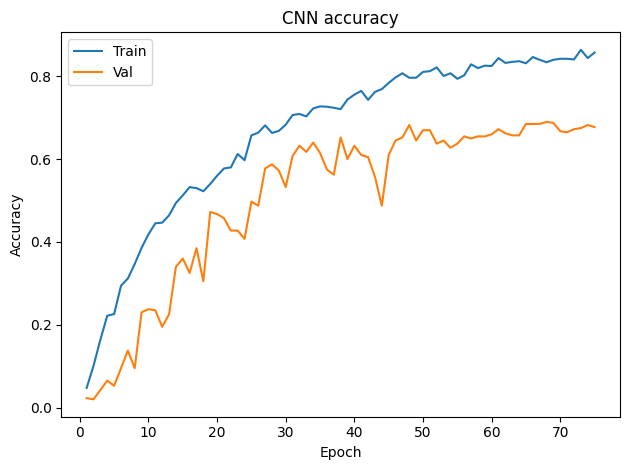

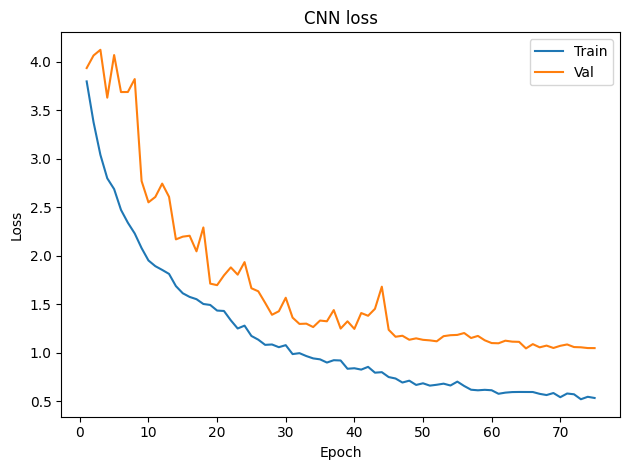

In [27]:
h = history.history
epochs = range(1, len(h["loss"]) + 1)

plt.figure()
plt.plot(epochs, h["accuracy"], label="Train")
plt.plot(epochs, h["val_accuracy"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("cnn_accuracy.png", dpi=300)
plt.show()

plt.figure()
plt.plot(epochs, h["loss"], label="Train")
plt.plot(epochs, h["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN loss")
plt.legend()
plt.tight_layout()
plt.savefig("cnn_loss.png", dpi=300)
plt.show()


In [28]:
train_eval = cnn.evaluate(train_ds, verbose=0)
val_eval   = cnn.evaluate(val_ds, verbose=0)
test_eval  = cnn.evaluate(test_ds, verbose=0)

print("\n=== Final evaluation ===")
print(f"Train accuracy: {train_eval[1]:.3f} | loss: {train_eval[0]:.3f}")
print(f"Val accuracy:   {val_eval[1]:.3f} | loss: {val_eval[0]:.3f}")
print(f"Test accuracy:  {test_eval[1]:.3f} | loss: {test_eval[0]:.3f}")



=== Final evaluation ===
Train accuracy: 0.952 | loss: 0.317
Val accuracy:   0.685 | loss: 1.046
Test accuracy:  0.640 | loss: 1.207


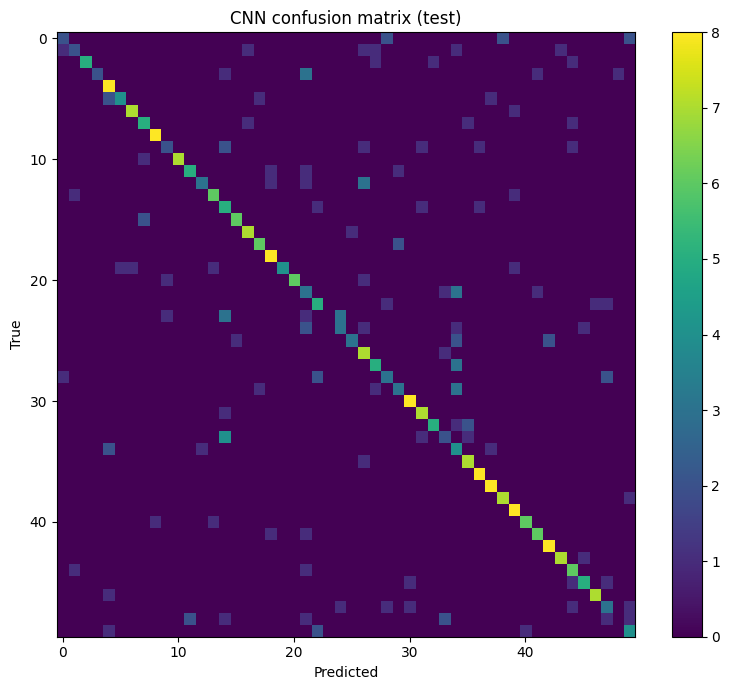

              precision    recall  f1-score   support

           0      0.500     0.250     0.333         8
           1      0.500     0.250     0.333         8
           2      1.000     0.625     0.769         8
           3      1.000     0.250     0.400         8
           4      0.571     1.000     0.727         8
           5      0.800     0.500     0.615         8
           6      0.875     0.875     0.875         8
           7      0.625     0.625     0.625         8
           8      0.889     1.000     0.941         8
           9      0.500     0.250     0.333         8
          10      1.000     0.875     0.933         8
          11      0.714     0.625     0.667         8
          12      0.750     0.375     0.500         8
          13      0.750     0.750     0.750         8
          14      0.294     0.625     0.400         8
          15      0.857     0.750     0.800         8
          16      0.778     0.875     0.824         8
          17      0.750    

In [29]:
y_prob = cnn.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_te_mel, y_pred)

plt.figure(figsize=(8, 7))
plt.imshow(cm, aspect="auto")
plt.title("CNN confusion matrix (test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("cnn_confusion_matrix.png", dpi=300)
plt.show()

print(classification_report(y_te_mel, y_pred, digits=3, zero_division=0))


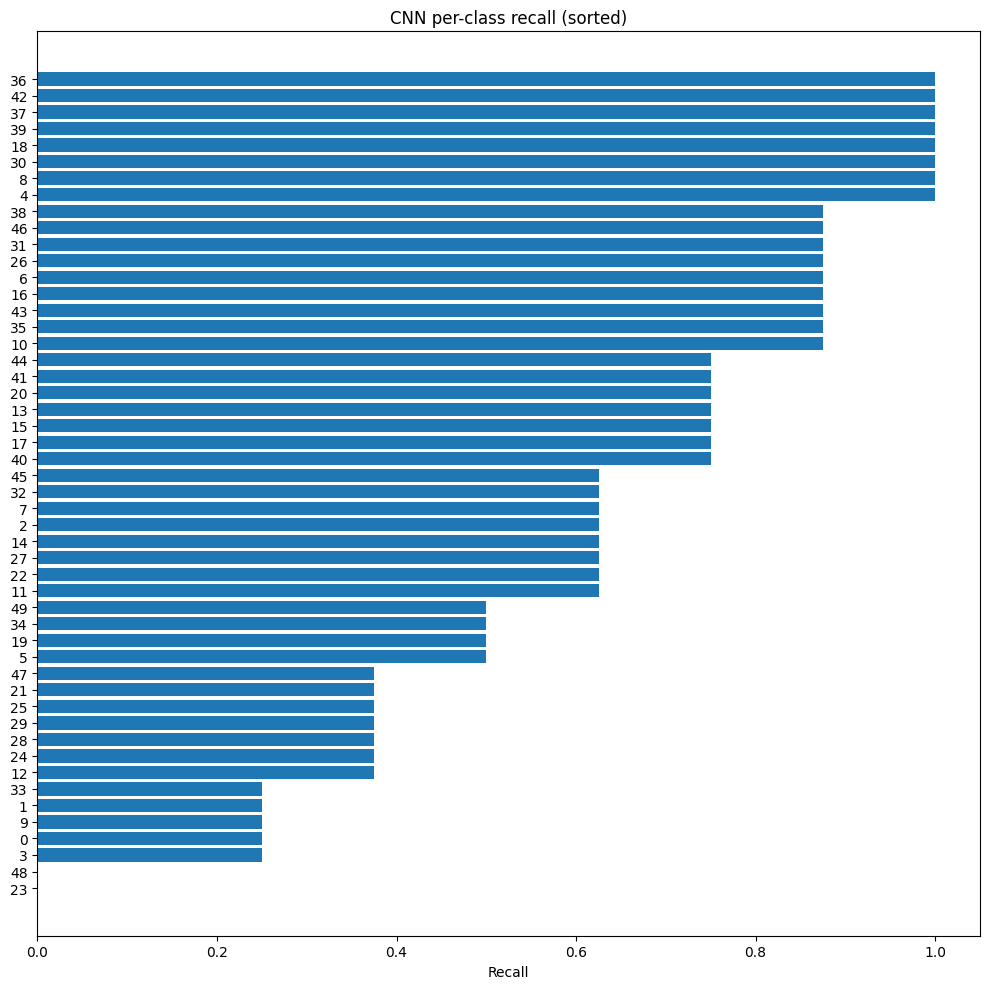

Worst classes:
23 0.0
48 0.0
3 0.24999999996875
0 0.24999999996875
9 0.24999999996875
Best classes:
36 0.999999999875
42 0.999999999875
37 0.999999999875
39 0.999999999875
18 0.999999999875


In [30]:
recall = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
order = np.argsort(recall)

plt.figure(figsize=(10, 10))
plt.barh(range(num_classes), recall[order])
plt.yticks(range(num_classes), order)
plt.xlabel("Recall")
plt.title("CNN per-class recall (sorted)")
plt.tight_layout()
plt.savefig("cnn_per_class_recall.png", dpi=300)
plt.show()

print("Worst classes:")
for i in order[:5]:
    print(i, recall[i])

print("Best classes:")
for i in order[-5:][::-1]:
    print(i, recall[i])


Misclassified: 144 / 400


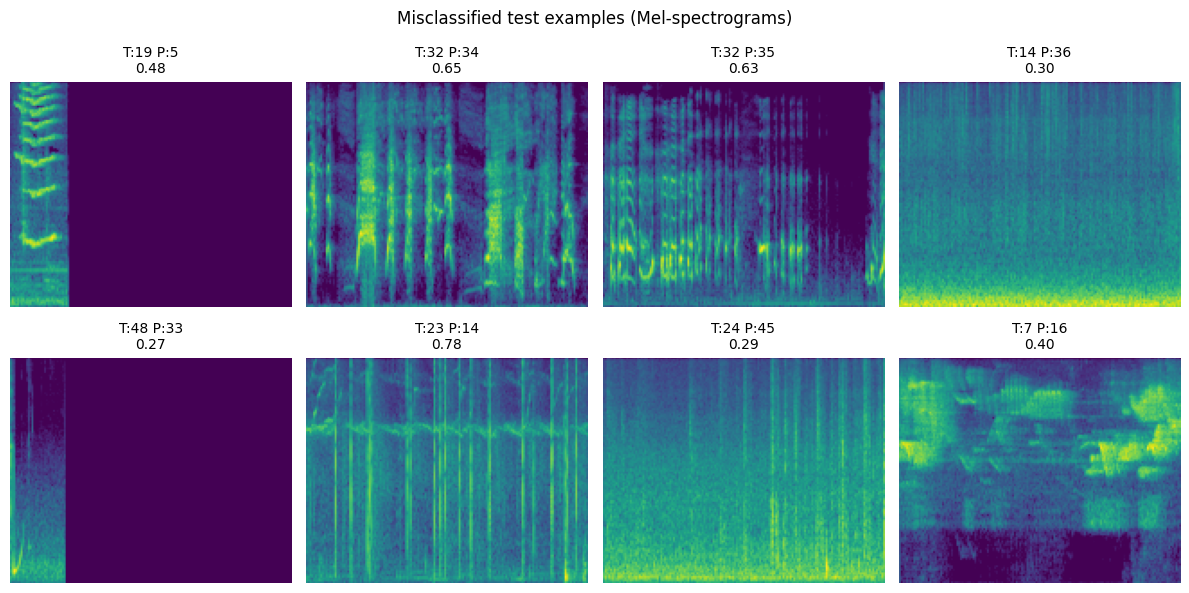

In [31]:
mis_idx = np.where(y_pred != y_te_mel)[0]
print("Misclassified:", len(mis_idx), "/", len(y_te_mel))

k = min(8, len(mis_idx))
pick = np.random.choice(mis_idx, size=k, replace=False)

plt.figure(figsize=(12, 6))
for j, idx in enumerate(pick, 1):
    plt.subplot(2, 4, j)
    plt.imshow(X_te_mel[idx], aspect="auto", origin="lower")
    t = y_te_mel[idx]
    p = y_pred[idx]
    conf = y_prob[idx, p]
    plt.title(f"T:{t} P:{p}\n{conf:.2f}", fontsize=10)
    plt.axis("off")

plt.suptitle("Misclassified test examples (Mel-spectrograms)")
plt.tight_layout()
plt.savefig("cnn_misclassified_grid.png", dpi=300)
plt.show()


In [46]:
import numpy as np

X_tr_seq = np.stack(X_train_mfcc_seq).astype(np.float32)
X_va_seq = np.stack(X_val_mfcc_seq).astype(np.float32)
X_te_seq = np.stack(X_test_mfcc_seq).astype(np.float32)

y_tr_seq = np.array(y_train_seq, dtype=np.int64)
y_va_seq = np.array(y_val_seq, dtype=np.int64)
y_te_seq = np.array(y_test_seq, dtype=np.int64)

print("Train:", X_tr_seq.shape, y_tr_seq.shape)
print("Val:  ", X_va_seq.shape, y_va_seq.shape)
print("Test: ", X_te_seq.shape, y_te_seq.shape)

T = X_tr_seq.shape[1]
F = X_tr_seq.shape[2]
num_classes = len(np.unique(y_tr_seq))
print("T =", T, "| F =", F, "| num_classes =", num_classes)


Train: (1200, 157, 40) (1200,)
Val:   (400, 157, 40) (400,)
Test:  (400, 157, 40) (400,)
T = 157 | F = 40 | num_classes = 50


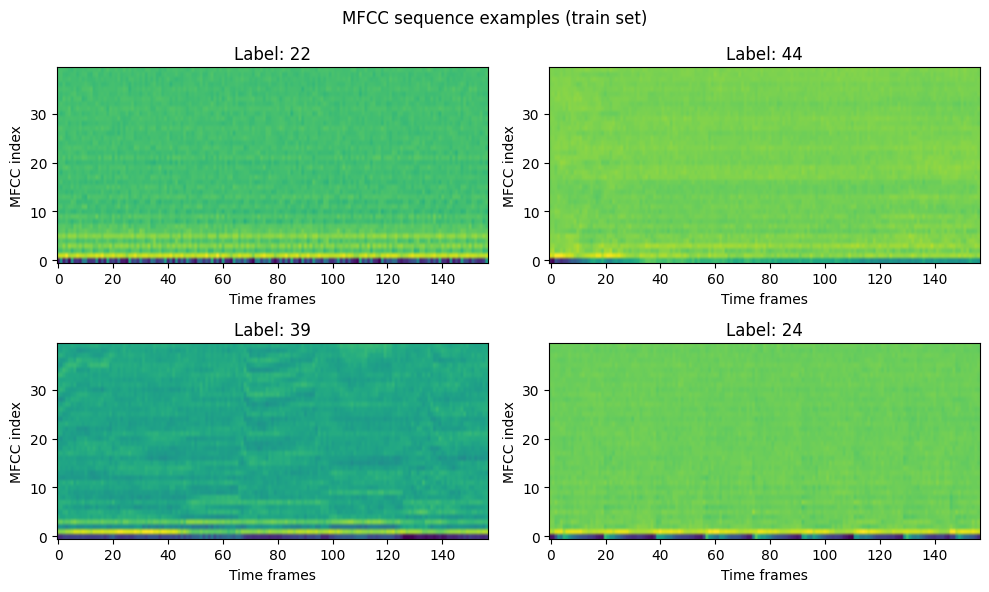

In [43]:
# Pick 4 random examples from train
idx = np.random.choice(len(X_tr_seq), size=4, replace=False)

plt.figure(figsize=(10, 6))
for i, k in enumerate(idx, 1):
    plt.subplot(2, 2, i)
    plt.imshow(X_tr_seq[k].T, aspect="auto", origin="lower")
    plt.title(f"Label: {y_tr_seq[k]}")
    plt.xlabel("Time frames")
    plt.ylabel("MFCC index")
    plt.tight_layout()

plt.suptitle("MFCC sequence examples (train set)")
plt.tight_layout()
plt.savefig("rnn_mfcc_examples_2x2.png", dpi=300)
plt.show()


In [44]:
inputs = keras.Input(shape=(T, F))  # (time, mfcc_features)

x = layers.GRU(128, return_sequences=True)(inputs)
x = layers.Dropout(0.30)(x)

x = layers.GRU(64)(x)
x = layers.Dropout(0.30)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.30)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

rnn = keras.Model(inputs, outputs, name="GRU_MFCC_Sequence")
rnn.summary()


Model: "GRU_MFCC_Sequence"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 157, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 157, 128)       │        65,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 157, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,298 (458.20 KB)

 Trainable params: 117,298 (458.20 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
import tensorflow as tf

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def per_example_standardize_seq(x):
    mean = tf.reduce_mean(x)
    std = tf.math.reduce_std(x) + 1e-6
    return (x - mean) / std

def make_ds_seq(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(min(len(X), 2000), reshuffle_each_iteration=True)
    ds = ds.map(lambda xx, yy: (per_example_standardize_seq(xx), yy),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds_seq = make_ds_seq(X_tr_seq, y_tr_seq, training=True)
val_ds_seq   = make_ds_seq(X_va_seq, y_va_seq, training=False)
test_ds_seq  = make_ds_seq(X_te_seq, y_te_seq, training=False)

print("train_ds_seq / val_ds_seq / test_ds_seq are ready.")


train_ds_seq / val_ds_seq / test_ds_seq are ready.


In [48]:
rnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1),
]

EPOCHS = 80
history_rnn = rnn.fit(
    train_ds_seq,
    validation_data=val_ds_seq,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.0267 - loss: 3.8973 - val_accuracy: 0.0450 - val_loss: 3.7824 - learning_rate: 0.0010
Epoch 2/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.0542 - loss: 3.7418 - val_accuracy: 0.0700 - val_loss: 3.6166 - learning_rate: 0.0010
Epoch 3/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.0642 - loss: 3.6082 - val_accuracy: 0.1075 - val_loss: 3.4814 - learning_rate: 0.0010
Epoch 4/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.0775 - loss: 3.4925 - val_accuracy: 0.1100 - val_loss: 3.3497 - learning_rate: 0.0010
Epoch 5/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.0942 - loss: 3.3433 - val_accuracy: 0.1400 - val_loss: 3.2460 - learning_rate: 0.0010
Epoch 6/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.1217 - loss: 3.2089 - val_accuracy: 0.1850 - val_loss: 3.1016 - learning_rate: 0.0010
Epoch 7/80
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.1600 - loss: 3.0253 - val_acc

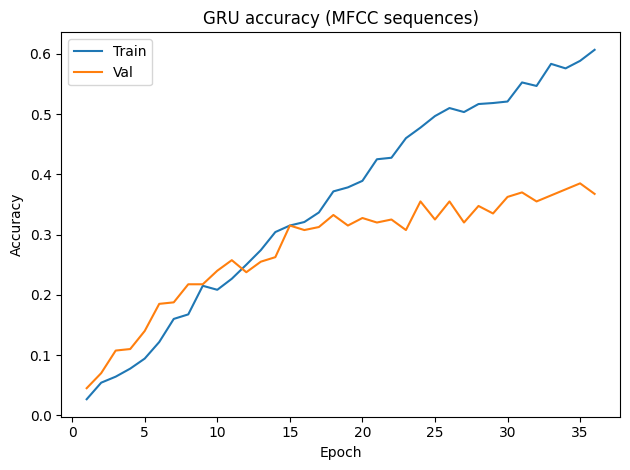

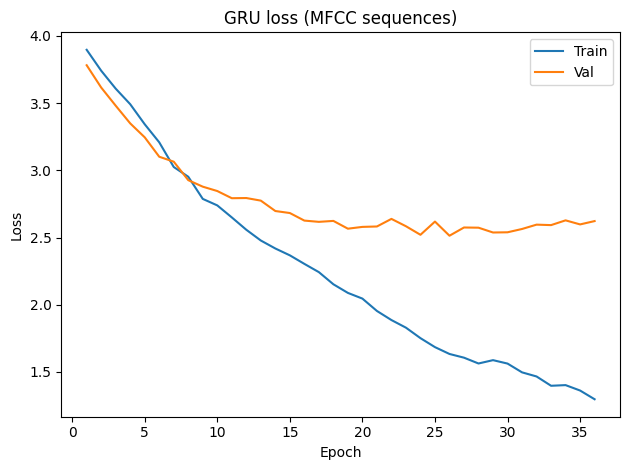

In [49]:
h = history_rnn.history
epochs = range(1, len(h["loss"]) + 1)

plt.figure()
plt.plot(epochs, h["accuracy"], label="Train")
plt.plot(epochs, h["val_accuracy"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GRU accuracy (MFCC sequences)")
plt.legend()
plt.tight_layout()
plt.savefig("rnn_accuracy.png", dpi=300)
plt.show()

plt.figure()
plt.plot(epochs, h["loss"], label="Train")
plt.plot(epochs, h["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GRU loss (MFCC sequences)")
plt.legend()
plt.tight_layout()
plt.savefig("rnn_loss.png", dpi=300)
plt.show()



=== Final evaluation (GRU on MFCC sequences) ===
Train accuracy: 0.618 | loss: 1.286
Val accuracy:   0.355 | loss: 2.514
Test accuracy:  0.303 | loss: 2.815


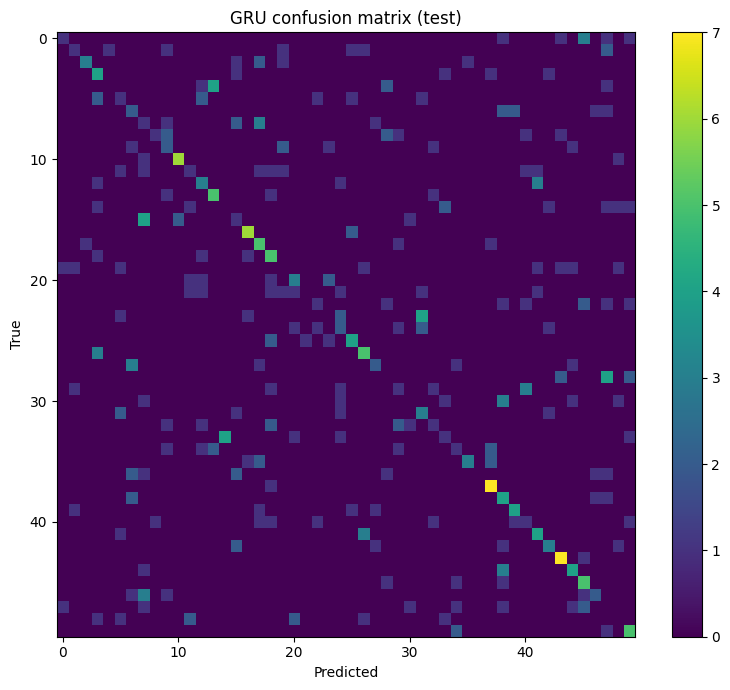

              precision    recall  f1-score   support

           0      0.333     0.125     0.182         8
           1      0.250     0.125     0.167         8
           2      0.750     0.375     0.500         8
           3      0.308     0.500     0.381         8
           4      0.000     0.000     0.000         8
           5      0.125     0.125     0.125         8
           6      0.182     0.250     0.211         8
           7      0.071     0.125     0.091         8
           8      0.500     0.125     0.200         8
           9      0.200     0.250     0.222         8
          10      0.750     0.750     0.750         8
          11      0.167     0.125     0.143         8
          12      0.273     0.375     0.316         8
          13      0.455     0.625     0.526         8
          14      0.000     0.000     0.000         8
          15      0.100     0.125     0.111         8
          16      0.667     0.750     0.706         8
          17      0.312    

In [50]:
train_eval = rnn.evaluate(train_ds_seq, verbose=0)
val_eval   = rnn.evaluate(val_ds_seq, verbose=0)
test_eval  = rnn.evaluate(test_ds_seq, verbose=0)

print("\n=== Final evaluation (GRU on MFCC sequences) ===")
print(f"Train accuracy: {train_eval[1]:.3f} | loss: {train_eval[0]:.3f}")
print(f"Val accuracy:   {val_eval[1]:.3f} | loss: {val_eval[0]:.3f}")
print(f"Test accuracy:  {test_eval[1]:.3f} | loss: {test_eval[0]:.3f}")

y_prob = rnn.predict(test_ds_seq, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_te_seq, y_pred, labels=np.arange(num_classes))

plt.figure(figsize=(8, 7))
plt.imshow(cm, aspect="auto")
plt.title("GRU confusion matrix (test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("rnn_confusion_matrix.png", dpi=300)
plt.show()

print(classification_report(y_te_seq, y_pred, digits=3, zero_division=0))


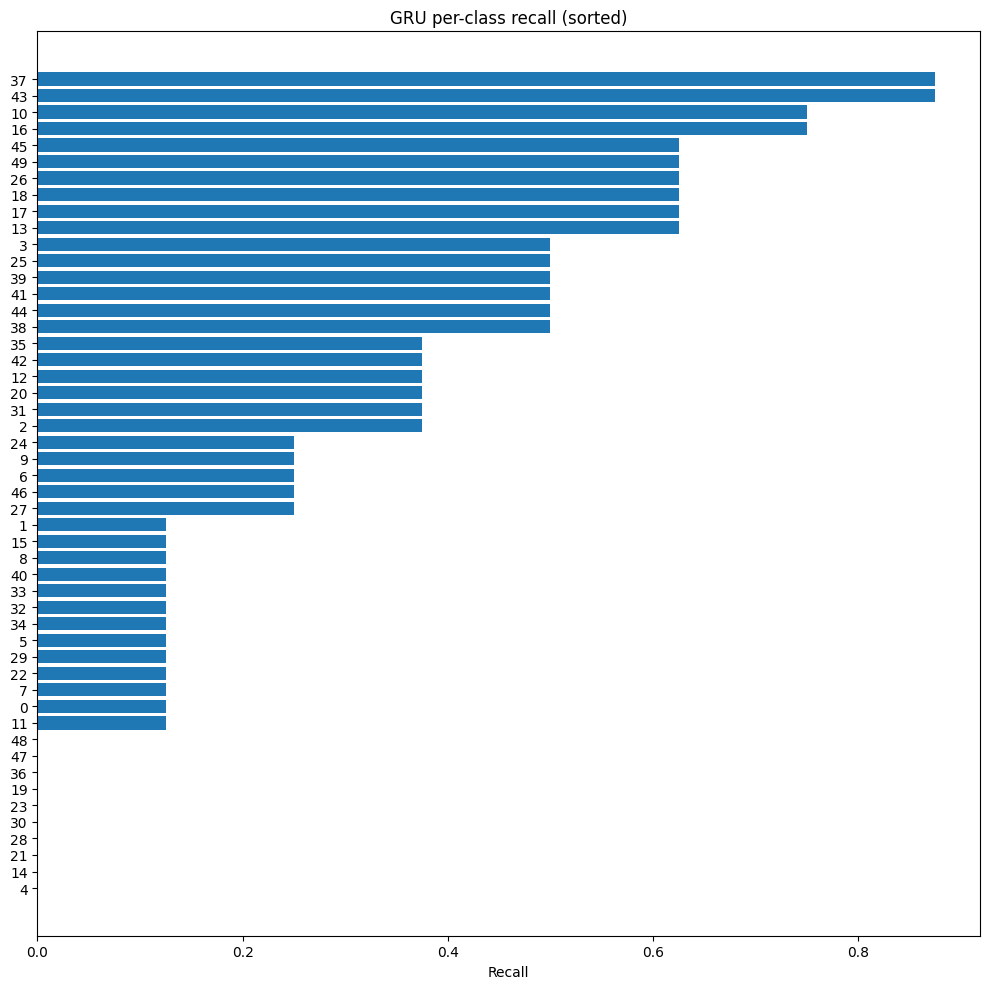

Worst classes:
4 recall = 0.0
14 recall = 0.0
21 recall = 0.0
28 recall = 0.0
30 recall = 0.0
Best classes:
37 recall = 0.874999999890625
43 recall = 0.874999999890625
10 recall = 0.74999999990625
16 recall = 0.74999999990625
45 recall = 0.624999999921875


In [51]:
recall = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
order = np.argsort(recall)

plt.figure(figsize=(10, 10))
plt.barh(range(num_classes), recall[order])
plt.yticks(range(num_classes), order)
plt.xlabel("Recall")
plt.title("GRU per-class recall (sorted)")
plt.tight_layout()
plt.savefig("rnn_per_class_recall.png", dpi=300)
plt.show()

print("Worst classes:")
for i in order[:5]:
    print(i, "recall =", float(recall[i]))

print("Best classes:")
for i in order[-5:][::-1]:
    print(i, "recall =", float(recall[i]))


Misclassified: 279 / 400


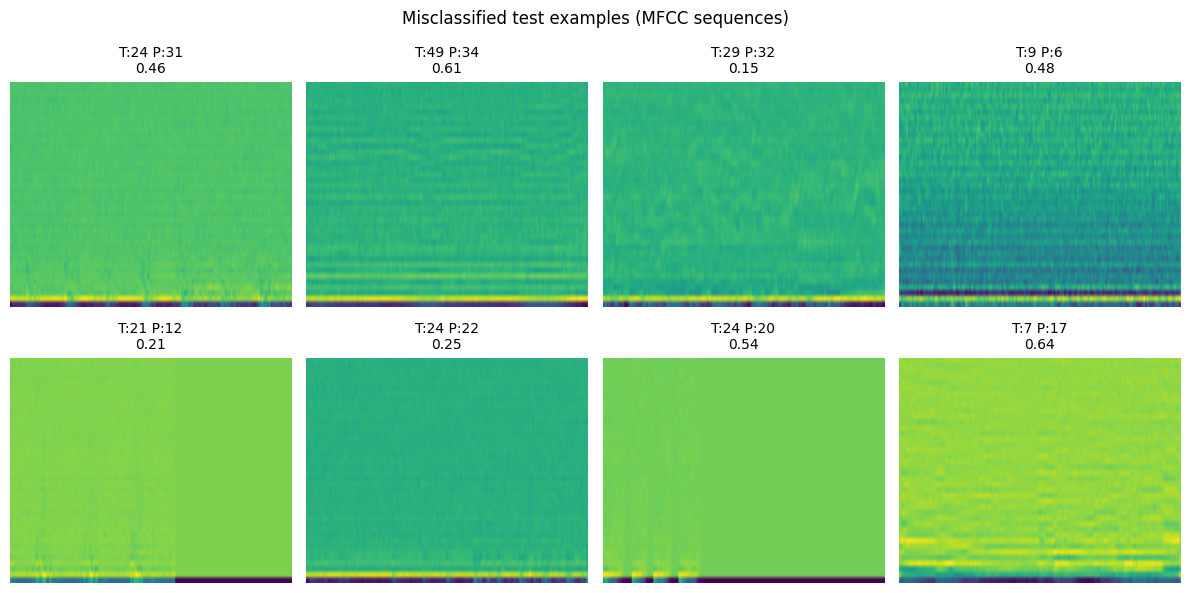

In [52]:
mis_idx = np.where(y_pred != y_te_seq)[0]
print("Misclassified:", len(mis_idx), "/", len(y_te_seq))

k = min(8, len(mis_idx))
pick = np.random.choice(mis_idx, size=k, replace=False)

plt.figure(figsize=(12, 6))
for j, idx in enumerate(pick, 1):
    plt.subplot(2, 4, j)
    plt.imshow(X_te_seq[idx].T, aspect="auto", origin="lower")
    t = int(y_te_seq[idx])
    p = int(y_pred[idx])
    conf = float(y_prob[idx, p])
    plt.title(f"T:{t} P:{p}\n{conf:.2f}", fontsize=10)
    plt.axis("off")

plt.suptitle("Misclassified test examples (MFCC sequences)")
plt.tight_layout()
plt.savefig("rnn_misclassified_grid.png", dpi=300)
plt.show()
